# Population inference with a gaussian toy model

## Case I: no selection effects

### MCMC analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl


%matplotlib inline
np.random.seed(12345)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

In [2]:
def gaussian(d,mu,Sigma_sq):
    
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

In [3]:
mean_min_prior = -5.0
mean_max_prior = 5.0

Sigma_sq_min_prior = -5.0
Sigma_sq_max_prior = 5.0

In [4]:
def log_likelihood(params, data):
    
    # Specify a set of flat priors.
    support = (
                (params[0] >= mean_min_prior)&
                (params[0] <= mean_max_prior)&
                (params[1] >= Sigma_sq_min_prior)&
                (params[1] <= Sigma_sq_max_prior)
                )
    
    #Likelihood is a gaussian with mean given by params[0] and Sigma given by params[1]
    
    log_likelihood = np.sum(np.log(gaussian(data,params[0],params[1])))
    out = np.where(support,log_likelihood,-np.inf)
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

In [75]:
"""
Injected data
"""

N_obs = 10000

# Hyperparameters to sample
true_mu = 0.5
true_Sigma_sq = 1.5

# Injecting noise.

Sigma = np.sqrt(true_Sigma_sq)
sigma = 0.1
std = np.sqrt(Sigma**2 + sigma**2)

data  = np.random.normal(true_mu,std,size=N_obs)

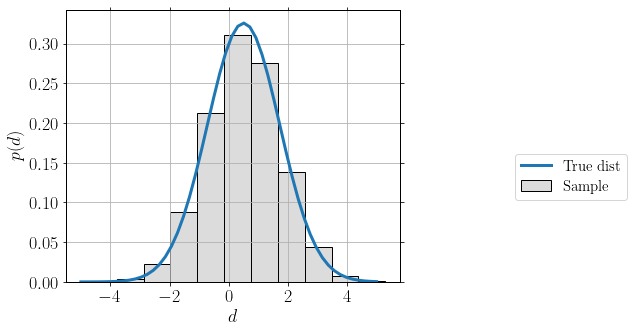

In [76]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(data,density=True,label='Sample',bins=10,histtype = 'bar',
                               color ='gainsboro', edgecolor='black')
plt.plot(np.linspace(mean_min_prior,mean_max_prior),
         gaussian(np.linspace(mean_min_prior,mean_max_prior),true_mu,true_Sigma_sq),
         lw=3,label='True dist')
plt.xlabel('$d$')
plt.ylabel('$p(d)$')
plt.legend(loc='best', bbox_to_anchor=(1.2, 0., 0.5, 0.5))

In [104]:
n_iter = 30000
ndim, nwalkers = 2, 16

pos_init0 = [true_mu, true_Sigma_sq + sigma**2]

p0 = pos_init0*(1+0.001* np.random.randn(8*len(pos_init0), len(pos_init0)))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])
sampler.run_mcmc(p0, n_iter, progress=True)

100%|██████████| 30000/30000 [01:27<00:00, 344.29it/s]


State([[0.50828818 1.5111364 ]
 [0.48011675 1.51412616]
 [0.52220415 1.50439598]
 [0.52199138 1.54905231]
 [0.52426203 1.53522889]
 [0.49501334 1.51430619]
 [0.49914118 1.50504564]
 [0.52461235 1.51527633]
 [0.499695   1.50158546]
 [0.51191497 1.51985019]
 [0.4949323  1.53032806]
 [0.50695569 1.49404315]
 [0.52079426 1.52269493]
 [0.48295063 1.5029071 ]
 [0.50249515 1.54529902]
 [0.51849008 1.52299202]], log_prob=[-16221.70760668 -16223.57115565 -16222.67066425 -16225.014038
 -16224.1270479  -16221.9762668  -16221.62578751 -16223.17366005
 -16221.5954171  -16222.12323477 -16222.69868572 -16221.63255272
 -16222.97521441 -16222.99077904 -16223.59625473 -16222.74945484], blobs=None, random_state=('MT19937', array([3802012673,  685864983,  606065897, 1671880712, 3806150557,
        430858802,  681537280, 4116247609, 2425099345,  501774067,
        810175957, 3711978233,  869602437, 2351810119,  217429328,
        506696577, 2870979171, 1679406604, 2279179826, 4129791138,
       2122180038,

In [105]:
"""
Collect the samples here.
"""
burnin = 1500

flat_samples = sampler.get_chain(discard=burnin, thin=1, flat=False)

In [106]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

org_samp = np.vstack( (
                       flat_samples[:,:,0].flatten() , 
                       flat_samples[:,:,1].flatten() 
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (456000, 2)
median =  [0.50394458 1.50212622]


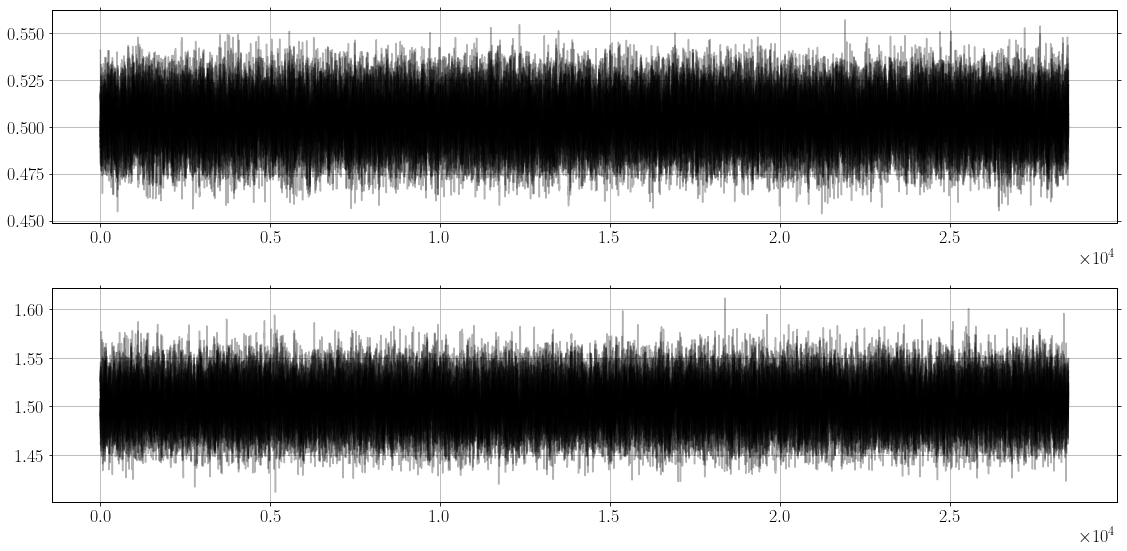

In [107]:
fig,ax = plt.subplots(len(pos_init0),figsize = (16,8))

ax[0].plot(flat_samples[:,:,0], "k", alpha=0.3)
ax[1].plot(flat_samples[:,:,1], "k", alpha=0.3)
plt.tight_layout()
plt.show()

In [113]:
# Nice plotting options for corner plots.

CORNER_KWARGS = dict(
    smooth=0.2, # smooths out contours. 
    plot_datapoints=True, # choose if you want datapoints
    label_kwargs=dict(fontsize=17.0), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=17.0), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=4, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

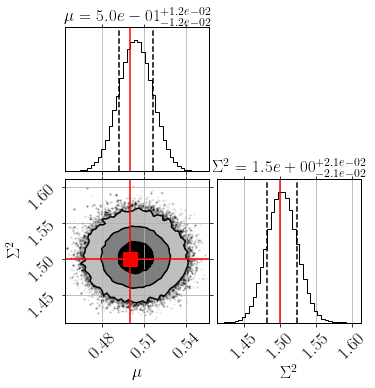

In [114]:
labels = [r'$\mu$',r'$\Sigma^2$']
truths=[true_mu, true_Sigma_sq]

fig = corner.corner(org_samp, bins=40,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

plt.show()

### Fisher estimates

In [115]:
Gamma_mu_mu = 1/(sigma**2 + true_Sigma_sq)
Gamma_Ssq_Ssq = 0.5*1/(sigma**2 + true_Sigma_sq)**2

Gamma_lambda = [[Gamma_mu_mu,0],[0,Gamma_Ssq_Ssq]]
Gamma_lambda_inv = np.linalg.inv(Gamma_lambda)

In [116]:
Dlambda_diag = 1/np.sqrt(N_obs) *  np.sqrt(np.diag(Gamma_lambda_inv))
Dmu, DSigma_sq = Dlambda_diag[0], Dlambda_diag[1]

print('FM widths',Dlambda_diag)
print('MCMC widths:',[np.round(np.sqrt(np.var(flat_samples[:,:,i])),30) 
                      for i in range(0,2)])

FM widths [0.01228821 0.02135462]
MCMC widths: [0.012277029314655213, 0.02122960402518128]


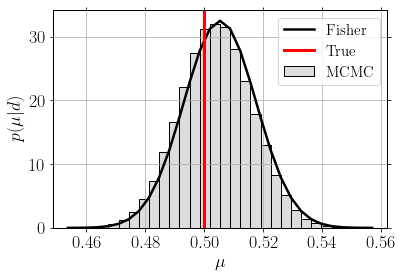

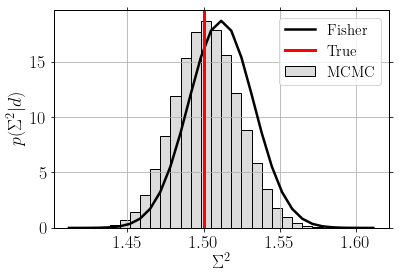

In [122]:
"""
Posteriors with Fisher estimates
"""


counts, bins, patches= plt.hist(flat_samples[:,:,0].flatten(), 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')

bins= np.array(bins)
plt.plot(bins, gaussian(bins,np.mean(bins),Dmu**2), color='black', lw=2.5, label='Fisher')

plt.axvline(x=truths[0], label='True', c='r',lw=3)
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

counts, bins, patches=plt.hist(flat_samples[:,:,1].flatten(), 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')

bins= np.array(bins)
plt.plot(bins, gaussian(bins,np.mean(bins),DSigma_sq**2), color='black', lw=2.5,label='Fisher')

plt.axvline(x=truths[1], label='True', c='r',lw=3)
plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()

## Case II: including selection effects

### MCMC analysis

In [123]:
d_th = 0.5 #threshold for data.
data_sel_bias = data[data > d_th]
N_det = len(data_sel_bias)
print('Number detected events:', N_det)

Number detected events: 5067


In [124]:
from scipy.special import erfc


def log_likelihood_selection_effect(params, data):
    
    # Specify a set of flat priors.
    support = (
                (params[0] >= mean_min_prior)&
                (params[0] <= mean_max_prior)&
                (params[1] >= Sigma_sq_min_prior)&
                (params[1] <= Sigma_sq_max_prior)
              )
    
    # Selection effect
    pdet_lambda = 0.5 * erfc((d_th - params[0])/np.sqrt(2 * params[1]))
    
    #Likelihood with selection effects
    log_likelihood = np.sum(np.log(gaussian(data,params[0],params[1])/pdet_lambda))
    out = np.where(support,log_likelihood,-np.inf)
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

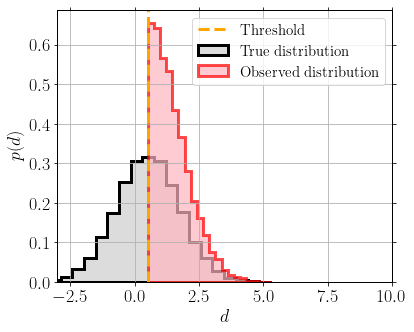

In [125]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(data,density=True,label='True distribution',bins=20, histtype = 'stepfilled',
         color='gainsboro', edgecolor='black',lw=3)
plt.hist(data_sel_bias,density=True,label='Observed distribution', bins=20,histtype = 'stepfilled',
         color='lightpink', edgecolor='red',lw=3,alpha=0.7)
plt.axvline(x=d_th, linestyle='-', c='orange', label='Threshold',ls='--', lw=3)
plt.xlabel('$d$')
plt.ylabel('$p(d)$')
plt.xlim(-3,10)
plt.legend(loc='best')

In [126]:
n_iter = 30000
ndim, nwalkers = 2, 16

pos_init0 = [true_mu, true_Sigma_sq+ sigma**2]

p0 = pos_init0*(1+0.01* np.random.randn(8*len(pos_init0), len(pos_init0)))

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                log_likelihood_selection_effect, args=[data_sel_bias])
sampler.run_mcmc(p0, n_iter, progress=True)

100%|██████████| 30000/30000 [00:58<00:00, 509.91it/s]


State([[0.42171031 1.5524676 ]
 [0.29284439 1.65959192]
 [0.43675951 1.59110158]
 [0.60067413 1.38474766]
 [0.46466238 1.54141834]
 [0.32536092 1.64578193]
 [0.47870333 1.5235407 ]
 [0.40336816 1.64422922]
 [0.33887006 1.66084928]
 [0.43370373 1.54211129]
 [0.46815963 1.43673865]
 [0.34740201 1.65168014]
 [0.44800532 1.54828187]
 [0.28231943 1.70069623]
 [0.35776191 1.60197164]
 [0.4374827  1.56005128]], log_prob=[-4679.83769941 -4680.91074683 -4680.85518072 -4682.67057147
 -4680.24211664 -4680.24106918 -4680.27460248 -4681.88656004
 -4680.25221934 -4679.8540259  -4683.80285171 -4680.17441171
 -4679.96430984 -4680.68302683 -4680.18826257 -4679.9397393 ], blobs=None, random_state=('MT19937', array([3802012673,  685864983,  606065897, 1671880712, 3806150557,
        430858802,  681537280, 4116247609, 2425099345,  501774067,
        810175957, 3711978233,  869602437, 2351810119,  217429328,
        506696577, 2870979171, 1679406604, 2279179826, 4129791138,
       2122180038,  796192029, 1

In [127]:
"""
Collect the samples here.
"""
burnin = 1500

flat_samples_selbias = sampler.get_chain(discard=burnin, thin=1, flat=False)

In [128]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

org_samp_selbias = np.vstack( (
                       flat_samples_selbias[:,:,0].flatten() , 
                       flat_samples_selbias[:,:,1].flatten() 
                      ) ).T
print("number of samples = ", np.shape(org_samp_selbias))
print("median = ", np.median(org_samp_selbias,axis=0))

number of samples =  (456000, 2)
median =  [0.39839134 1.58541411]


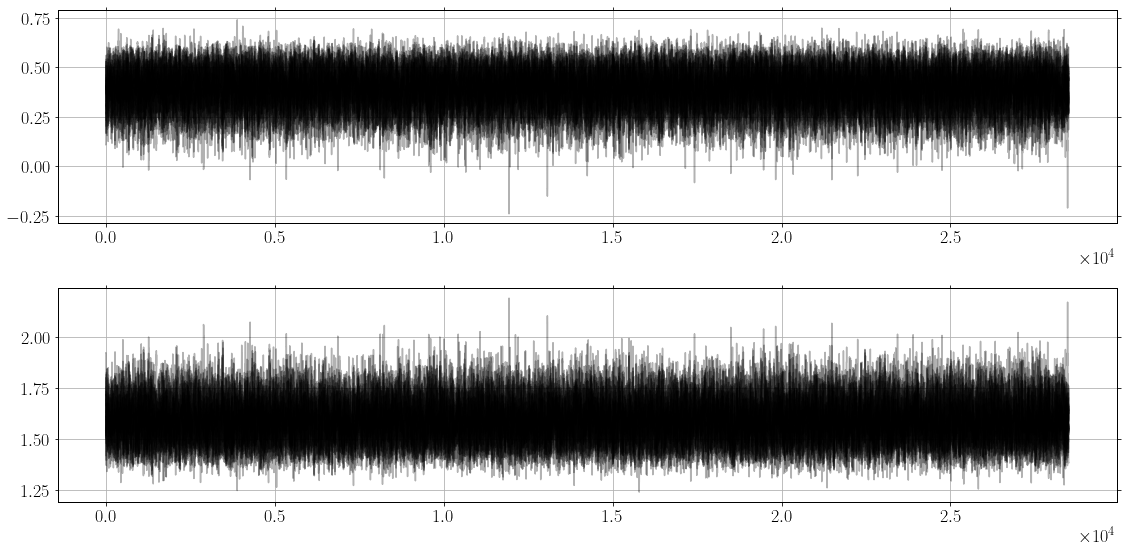

In [129]:
fig,ax = plt.subplots(len(pos_init0),figsize = (16,8))

ax[0].plot(flat_samples_selbias[:,:,0], "k", alpha=0.3)
ax[1].plot(flat_samples_selbias[:,:,1], "k", alpha=0.3)
plt.tight_layout()
plt.show()

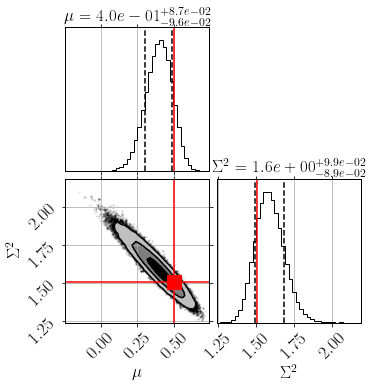

In [130]:
import matplotlib.patches as mpatches

labels = [r'$\mu$',r'$\Sigma^2$']
truths=[true_mu, true_Sigma_sq+sigma**2]

corner.corner(org_samp_selbias, bins=40,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)
plt.show()

### Fisher estimates

In [131]:
# Useful definitions

sigmasq_plus_Sigmasq =  sigma**2 + true_Sigma_sq


pdet_lambda_true = 0.5 * erfc((d_th - true_mu)/np.sqrt(2 * sigmasq_plus_Sigmasq))
pof_dth_lambda = np.exp(-0.5* (d_th - true_mu)**2/sigmasq_plus_Sigmasq)/np.sqrt(2*np.pi * sigmasq_plus_Sigmasq)

dpdet_dmu_sq = (d_th - true_mu) * pof_dth_lambda /sigmasq_plus_Sigmasq
dpdet_dmudSigmasq = 0.5 * pof_dth_lambda *  (d_th**2 - 2 * d_th * true_mu + true_mu**2 - sigmasq_plus_Sigmasq)/ sigmasq_plus_Sigmasq**2
dpdet_dSigmasq_sq = 1./4. * (d_th - true_mu) * pof_dth_lambda* (d_th**2 - 2 * d_th * true_mu + true_mu**2 -3* sigmasq_plus_Sigmasq)/sigmasq_plus_Sigmasq**3


In [132]:
Gamma_mu_mu_selbias = 1/sigmasq_plus_Sigmasq + dpdet_dmu_sq
Gamma_mu_Ssq_selbias = 1/sigmasq_plus_Sigmasq * pof_dth_lambda/pdet_lambda_true + dpdet_dmudSigmasq
Gamma_Ssq_Ssq_selbias = 0.5 * 1/sigmasq_plus_Sigmasq**2 + (d_th - true_mu)/sigmasq_plus_Sigmasq**2 * pof_dth_lambda/pdet_lambda_true + dpdet_dSigmasq_sq 


In [133]:
Gamma_lambda_selbias =[[Gamma_mu_mu_selbias,Gamma_mu_Ssq_selbias],[Gamma_mu_Ssq_selbias,Gamma_Ssq_Ssq_selbias]]
Gamma_lambda_selbias_inv = np.linalg.inv(Gamma_lambda_selbias)

In [134]:
Dlambda_diag_selbias = 1/np.sqrt(N_det) *  np.sqrt(np.diag(Gamma_lambda_selbias_inv))
Dmu_selbias, DSigma_sq_selbias = Dlambda_diag_selbias[0], Dlambda_diag_selbias[1]

print('FM widths',Dlambda_diag_selbias)
print('MCMC widths:',[np.round(np.sqrt(np.var(flat_samples_selbias[:,:,i])),30) 
                      for i in range(0,2)])

FM widths [0.03240445 0.05631294]
MCMC widths: [0.0920625924170741, 0.09504123154999171]


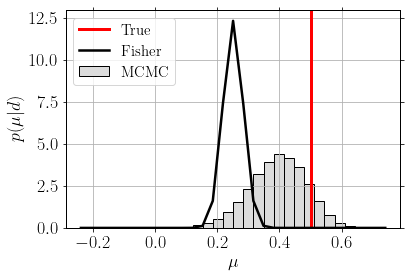

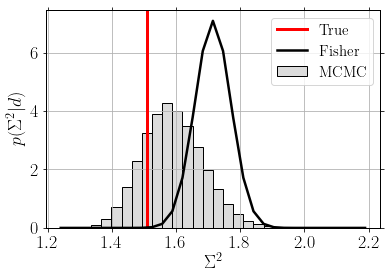

In [135]:
# Mean

plt.axvline(x=truths[0], label='True', c='r',linestyle='-',lw=3)
counts, bins, patches= plt.hist(flat_samples_selbias[:,:,0].flatten(), 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')
bins= np.array(bins)
plt.plot(bins, gaussian(bins,np.mean(bins),Dmu_selbias**2), color='black', lw=2.5, label='Fisher')

plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

# Variance

plt.axvline(x=truths[1], label='True', c='r',linestyle='-',lw=3)
counts, bins, patches=plt.hist(flat_samples_selbias[:,:,1].flatten(), 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')
bins= np.array(bins)
plt.plot(bins, gaussian(bins,np.mean(bins),DSigma_sq_selbias**2), color='black', lw=2.5, label='Fisher')

plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()